# What am I Investigating?
Tennis is a racquet sport that can be played individually against a single opponent (singles) or between two teams of two players each (doubles). Players use a strung racquet to strike a hollow rubber ball, covered with felt, over a net and into the opponent's court. The objective of the game is to play the ball in such a way that the opponent cannot play a valid return. The player who is unable to return the ball will not gain a point, while the opposite player will.  
Tennis is played on different surfaces, including grass, clay, hard courts, and even indoor carpet. Each surface affects the ball's speed and bounce differently, leading to varied styles of play. In this project I'm investigating the relationship between the type of surface on which the match was played on to various stats (such as the duration of the match, the number of aces, etc.).  


---


The data is taken from kaggle and is called ['Huge Tennis Database'](https://www.kaggle.com/datasets/guillemservera/tennis). This dataset is a comprehensive collection of ATP tennis rankings, match results, and player statistics. It is derived from the original database created and maintained by Jeff Sackmann, which could be found in the [following github repository](https://github.com/JeffSackmann/tennis_atp).  
On kaggle there are two methods for importing this data - by using SQLlite or by using CSV files. I chose to download the CSV files regarding all the ATP matches conducted between 1968 and 2023. Because the data of each year's matches is stored in a separate CSV file, I had to concatenate them.

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, kurtosis

pd.set_option('display.max_columns', 50)

# Loading Data

In [ ]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [ ]:
combined_df.sample(10)

# Understanding the Big Picture

Getting the number of rows and columns in the dataset (pre-cleaning):

In [ ]:
number_of_rows_pre_cleaning = combined_df.shape[0]
number_of_columns_pre_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_pre_cleaning} rows and {number_of_columns_pre_cleaning} columns.")

Examining the data type of all the columns in the dataset:

In [ ]:
combined_df.dtypes

*After examining the data types of all the columns, I can see a problem with some of the columns. Though some of the variables are discrete, Pandas falsely attributed them to `float64`.  
In the data cleaning section I'll change the data type of those columns to the smaller data type in order to reduce memory usage.*

Getting the descriptive statistics of the numeric variables:

In [ ]:
combined_df.describe()

Counting the number of NA's in each column:

In [ ]:
combined_df.isna().sum()

*While examining the number of NA's in each column, my main focus is on the number of NA's in the variables depicting the match stats, because I intened the analyze them.*

Checking if there are any duplicate rows:

In [ ]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

# Data Cleaning

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [ ]:
combined_df["tourney_date"] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df["tourney_date"].head()

Dividing the 'tourney_date' column to year, month and day

In [ ]:
combined_df["Year"] = combined_df["tourney_date"].dt.strftime('%Y')
combined_df["Month"] = combined_df["tourney_date"].dt.strftime('%m')
combined_df["Day"] = combined_df["tourney_date"].dt.strftime('%d')
combined_df[["Year", "Month", "Day"]].head(10)

Deleting matches (rows) that we don't know their statistics:

In [ ]:
match_stats_columns_names = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced"]

matches_without_stats_df = combined_df[combined_df[match_stats_columns_names].isna().any(axis=1)]

matches_without_stats_df.head(10)

In [20]:
number_of_NA_by_Year_and_tourney_level_df = matches_without_stats_df.groupby(by=["Year", "tourney_level"], as_index=False)[match_stats_columns_names].apply(lambda x: x.isna().sum())
number_of_NA_by_Year_and_tourney_level_df.dtypes

Year             object
tourney_level    object
w_ace             int64
w_df              int64
w_svpt            int64
w_1stIn           int64
w_1stWon          int64
w_2ndWon          int64
w_SvGms           int64
w_bpSaved         int64
w_bpFaced         int64
l_ace             int64
l_df              int64
l_svpt            int64
l_1stIn           int64
l_1stWon          int64
l_2ndWon          int64
l_SvGms           int64
l_bpSaved         int64
l_bpFaced         int64
dtype: object

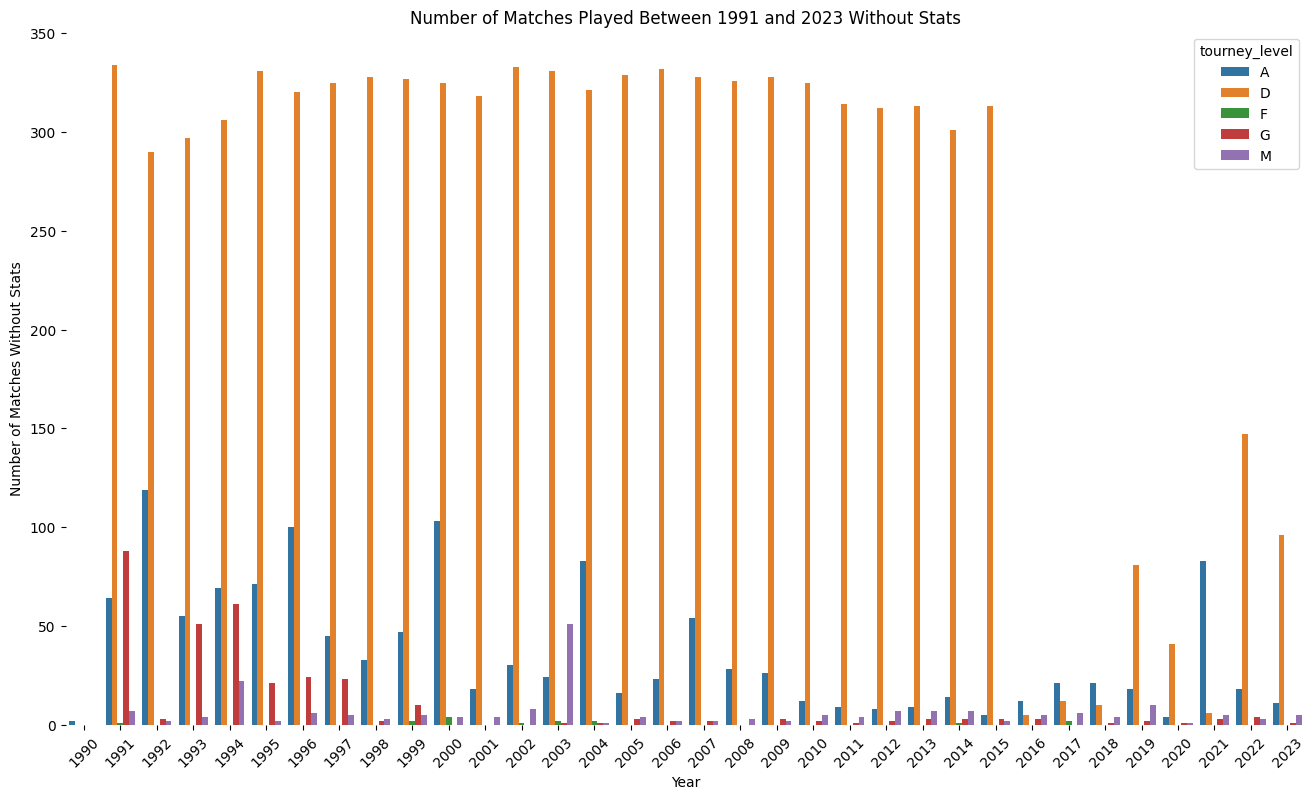

In [31]:
# Creating the plot
plt.figure(figsize=(16, 9))
NA_by_year_and_tourney_level_barplot = sns.barplot(data=number_of_NA_by_Year_and_tourney_level_df, x="Year", y="w_ace", hue="tourney_level")

# Removing the frame
sns.despine(left=True, bottom=True)

# Rotating tick labels of the X axis
plt.xticks(rotation=45)

# Titles
NA_by_year_and_tourney_level_barplot.set_xlabel("Year")
NA_by_year_and_tourney_level_barplot.set_ylabel("Number of Matches Without Stats")
NA_by_year_and_tourney_level_barplot.set_title("Number of Matches Played Between 1991 and 2023 Without Stats")

# Showing the plot
plt.show()

In [ ]:
combined_df.dropna(subset=match_stats_columns_names, inplace=True)

combined_df[match_stats_columns_names].isna().sum() # If the code above worked, the columns in the list above should have 0 NA's.

In the "understanding the big picture" section I counted the number of [NA's in each column](https://colab.research.google.com/drive/1YiNo6ZBjWNuTTT72mS8qQZ_2W1ZzAFnL#scrollTo=INYVRYc3RsLx&line=1&uniqifier=1). As can be seen, we don't have the stats for 10,207 matches - which is 9.75% of the matches we had in the initial dataframe (we had information on 104,682 at the beginning).

Converting all the match stats columns from float64 to int64:

In [ ]:
for col in match_stats_columns_names:
    combined_df[col] = pd.to_numeric(combined_df[col], downcast='integer')

combined_df.dtypes

Checking is the descriptive statistics of some of the variables changed after the data type conversion:

In [ ]:
combined_df[match_stats_columns_names].describe()

Deleting unnecessary columns:

In [ ]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"]

combined_df.drop(columns=names_of_columns_to_drop, inplace=True)

combined_df.columns

Creating new columns:

In [ ]:
# "total_points" - total points played in the match (sum of the serve points both the winner and the loser had).
combined_df["total_points"] = combined_df["w_svpt"] + combined_df["l_svpt"]

# "w_1st_percentage" - the winners' percentage of first serve in
combined_df["w_1st_percentage"] = combined_df["w_1stIn"]/combined_df["w_svpt"]
combined_df["w_1st_percentage"] = round(combined_df["w_1st_percentage"]*100, 3)

# "l_1st_percentage" - the losers' percentage of first serve in
combined_df["l_1st_percentage"] = combined_df["l_1stIn"]/combined_df["l_svpt"]
combined_df["l_1st_percentage"] = round(combined_df["l_1st_percentage"]*100, 3)

combined_df[["total_points", "w_svpt", "w_1stIn", "w_1st_percentage", "l_svpt", "l_1stIn", "l_1st_percentage"]].sample(10)

Getting the number of rows and columns in the dataset (post-cleaning):

In [ ]:
number_of_new_columns_added = 3 # Nothe that this doesn't automatically counts the numebr of new columns added to the DF. Update if necessary
number_of_rows_post_cleaning = combined_df.shape[0]
number_of_columns_post_cleaning = combined_df.shape[1] - number_of_new_columns_added

print(f"The dataset has {number_of_rows_post_cleaning} rows and {number_of_columns_post_cleaning+number_of_new_columns_added} columns.")
print(f"{number_of_rows_pre_cleaning-number_of_rows_post_cleaning} rows were deleted and {number_of_columns_pre_cleaning-number_of_columns_post_cleaning} columns were removed. {number_of_new_columns_added} new columns were created based on existing variabels.")

# Data Preprocessing

Creating a subset used in the multivariate analysis:

In [ ]:
col_names_multivariate_df = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced", "winner_ht", "winner_age", "loser_ht", "loser_age", "minutes", "total_points", "w_1st_percentage", "l_1st_percentage"]

multivariate_analysis_df = combined_df[col_names_multivariate_df]

multivariate_analysis_df.head()

Creating a new subset for the 1st serve by surface analysis:

In [ ]:
first_serve_by_surface_df = pd.melt(combined_df, id_vars = "surface", value_vars=["w_1st_percentage", "l_1st_percentage"])
first_serve_by_surface_df.sample(10)

# Univariate Analysis

## Categorical Variables

### Surface Type

Counting the number of games played on each surface:

In [ ]:
combined_df["surface"].value_counts()

Proportion of matches played on each surface:

In [ ]:
combined_df["surface"].value_counts(normalize=True)

Plotting the number of games played on each surface type:

In [ ]:
# Creating the plot
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')

# Titles
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")

# Showing the plot
plt.show()

### Best of 5 VS Best of 3:

Counting the number of best of 5 and best of 3 matches played:

In [ ]:
combined_df["best_of"].value_counts()

Proportion of each best of- match:

In [ ]:
combined_df["best_of"].value_counts(normalize=True)

Plotting the number of best of 5 and best of 3 matches played:

In [ ]:
# Creating the plot
plt.figure(figsize=(12,6))
best_of_countplot = sns.countplot(data=combined_df, x="best_of", order=combined_df.best_of.value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
best_of_countplot.bar_label(best_of_countplot.containers[0], label_type='edge')

# Titles
best_of_countplot.set_xlabel("Best of How Many Sets")
best_of_countplot.set_ylabel("Number of Matches")
best_of_countplot.set_title("Number of Matches Played Between 1991 and 2023")

# Showing the plot
plt.show()

### Number of Matches by Tournament Type:

Counting the number of matches in each tournament type:

In [ ]:
combined_df["tourney_level"].value_counts()

Proportion of tournament type:

In [ ]:
combined_df["tourney_level"].value_counts(normalize=True)

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12,6))
tourney_level_countplot = sns.countplot(data=combined_df, x="tourney_level", order=combined_df["tourney_level"].value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
tourney_level_countplot.bar_label(tourney_level_countplot.containers[0], label_type='edge')

# Titles
tourney_level_countplot.set_xlabel("Tourney Type")
tourney_level_countplot.set_ylabel("Number of Matches")
tourney_level_countplot.set_title("Number of Matches Played Between 1991 and 2023 in each tourney type")

# Showing the plot
plt.show()

## Numerical Variables

### Analyzing the total_points variable:

Descriptive statistics:

In [ ]:
round(combined_df.total_points.describe(), 3)

Skewness and Kurtosis:

In [ ]:
total_points_skewness = combined_df.total_points.skew()
total_points_kurtosis = combined_df.total_points.kurtosis()

print(f"Skewness: {round(total_points_skewness, 3)}")
print(f"Kurtosis: {round(total_points_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")

# Showing the plot
plt.show()

### Analyzing the winner_age variable:

Descriptive statistics:

In [ ]:
round(combined_df["winner_age"].describe(), 3)

Skewness and Kurtosis:

In [ ]:
winner_age_skewness = combined_df["winner_age"].skew()
winner_age_kurtosis = combined_df["winner_age"].kurtosis()

print(f"Skewness: {round(winner_age_skewness, 3)}")
print(f"Kurtosis: {round(winner_age_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
winner_age_histogram = sns.histplot(data=combined_df, x="winner_age")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
winner_age_histogram.set_xlabel("Winners Age")
winner_age_histogram.set_ylabel("Number of Players")
winner_age_histogram.set_title("Winners Age Distribution")

# Showing the plot
plt.show()

### Analyzing the loser_age variable:

Descriptive statistics:

In [ ]:
combined_df["loser_age"].describe()

Skewness and Kurtosis:

In [ ]:
loser_age_skewness = combined_df["loser_age"].skew()
loser_age_kurtosis = combined_df["loser_age"].kurtosis()

print(f"Skewness: {round(loser_age_skewness, 3)}")
print(f"Kurtosis: {round(loser_age_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
loser_age_histogram = sns.histplot(data=combined_df, x="loser_age")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
loser_age_histogram.set_xlabel("Loser Age")
loser_age_histogram.set_ylabel("Number of Players")
loser_age_histogram.set_title("Losers Age Distribution")

# Showing the plot
plt.show()

### Analyzing the w_1st_percentage variable:

Descriptive statistics:

In [ ]:
combined_df["w_1st_percentage"].describe()

Skewness and Kurtosis:

In [ ]:
w_1st_percentage_skewness = combined_df["w_1st_percentage"].skew()
w_1st_percentage_kurtosis = combined_df["w_1st_percentage"].kurtosis()

print(f"Skewness: {round(w_1st_percentage_skewness, 3)}")
print(f"Kurtosis: {round(w_1st_percentage_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
w_1st_percentage_histogram = sns.histplot(data=combined_df, x="w_1st_percentage")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
w_1st_percentage_histogram.set_xlabel("Winner's First Serve In Percentage")
w_1st_percentage_histogram.set_ylabel("Number of Players")
w_1st_percentage_histogram.set_title("Winner's First Serve In Percentage Distribution")

# Showing the plot
plt.show()

### Analyzing the l_1st_percentage variable:

Descriptive statistics:

In [ ]:
combined_df["l_1st_percentage"].describe()

Skewness and Kurtosis:

In [ ]:
l_1st_percentage_skewness = combined_df["l_1st_percentage"].skew()
l_1st_percentage_kurtosis = combined_df["l_1st_percentage"].kurtosis()

print(f"Skewness: {round(l_1st_percentage_skewness, 3)}")
print(f"Kurtosis: {round(l_1st_percentage_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
l_1st_percentage_histogram = sns.histplot(data=combined_df, x="l_1st_percentage")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
l_1st_percentage_histogram.set_xlabel("Loser's First Serve In Percentage")
l_1st_percentage_histogram.set_ylabel("Number of Players")
l_1st_percentage_histogram.set_title("Loser's First Serve In Percentage Distribution")

# Showing the plot
plt.show()

# Bivariate Analysis

## Finding trends in the numric variables:

* The goal of the pairplot visualization is to examine the relationships between all the numric variabels in the dataset. Though in many cases a correlation matrix is used to do so, I prefer to do this visualization in order to see if there's any non linear correlations between any variabels.

Creating a pairplot visualization:

In [ ]:
pairplot = sns.pairplot(multivariate_analysis_df, corner=True)
plt.show()

* I chose to create the correlation matrix in order to check the magnitude of the linear correlation between variabels.  

Creating a correlation matrix:

In [ ]:
corr_matrix = round(multivariate_analysis_df.corr(),2)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, mask=mask, square=True, linewidths=2)
plt.show()

**Conclusions drawn from the pairplot visualization and correlation matrix:**  
* After examining the pairplot visualization, it seems that the only type of relationships are linear.
* From examining the correlation matrix, it seems that there is a strong correlation between some variabels. All of the strong correlations make sense - the correlation between the length of the match in minutes to the total number of points played in the match (*r=0.92*), for example, is easy to explain: if the match is longer, it means the players has more time to play more points.

## Comparing the average number of total points played on each surfce

Calculating each surface's average:

In [ ]:
total_points_mean_by_surface_df = round(combined_df.groupby(["surface"], as_index=False)[["total_points"]].mean(), 2)
total_points_mean_by_surface_df.sort_values(by="total_points", ascending=False, inplace=True, ignore_index=True)
total_points_mean_by_surface_df

Plotting:

In [ ]:
plt.figure(figsize=(16,9))
points_by_surface_plot = sns.boxplot(combined_df, x="surface", y="total_points", order=total_points_mean_by_surface_df["surface"])
sns.despine(left=True, bottom=True)
points_by_surface_plot.set_xlabel("Surface Type")
points_by_surface_plot.set_ylabel("Number of Points Played In A Match")
points_by_surface_plot.set_title("Total Points On Each Surface")
plt.show()

## Comparing the average match length for each event

In [ ]:
average_duration_by_tourney_level_df = round(combined_df.groupby(["tourney_level"], as_index=False)[["minutes", "total_points"]].mean(), 3)
average_duration_by_tourney_level_df.sort_values(by="minutes", ascending=False, inplace=True, ignore_index=True)
average_duration_by_tourney_level_df

In [ ]:
plt.figure(figsize=(16,9))
duration_by_tourney_level_plot = sns.boxplot(combined_df, x="tourney_level", y="minutes", order=average_duration_by_tourney_level_df["tourney_level"])
sns.despine(left=True, bottom=True)
duration_by_tourney_level_plot.set_xlabel("Tourney Level")
duration_by_tourney_level_plot.set_ylabel("Match Duration, in Minutes")
duration_by_tourney_level_plot.set_title("Match Duration in Minutes by Tourney Level")
plt.show()

## First Serve Percentage Difference Between Winners and Losers:

In [ ]:
round(combined_df[["w_1st_percentage", "l_1st_percentage"]].mean(), 3)

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(data=combined_df[["w_1st_percentage", "l_1st_percentage"]])
sns.despine(left=True, bottom=True)

plt.show()

## Comparing the 1st serve percentages per surface

In [ ]:
first_serve_percentages_per_surface_df = round(first_serve_by_surface_df.groupby(["surface", "variable"], as_index=False).agg({"value": ["mean", "median"]}), 3)
first_serve_percentages_per_surface_df.sort_values(by=["surface", ("value", "median")], ascending=[True, False], inplace=True, ignore_index=True)
first_serve_percentages_per_surface_df

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(data=first_serve_by_surface_df, x="surface", y="value", hue="variable")
sns.despine(left=True, bottom=True)